## 2. Data_download_and_save_to_EOPatches (Collection 1 Level 1)
#### Final set up for data collection

0. Load required libraries and  site dependant constants and utility functions:
1. Display Greenland contour and selected tiles.
2. Set up Sentinel Hub INSTANCE
3. Landsat 8 data downlaod
4. Landsat 8 data visualization

### 0. Load required libraries,  area dependant constants and utility functions:


In [4]:
# required libraries:
import os
import geopandas as gpd
from sentinelhub import CRS, BBox
import matplotlib.pyplot as plt
# Add to python path parent dictionary
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN IMPORT DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

In [2]:
SELECTED_CRS = site.AVAILABLE_CRSs[0]
SELECTED_DATE_RANGE = site.DATE_RANGES_LANDSAT_8[0]
SELECTED_PATCHES = site.SELECTED_PATCH_INDEXES_PER_UTM_ZONE_DIC[SELECTED_CRS.name]

In [3]:
print('You are about to download following data:')
print('SITE_NAME:', site.SITE_NAME)
print('AVAILABLE CRSes:', str(site.AVAILABLE_CRSs))
print('DATA PRODUCTS', str(site.DATA_PRODUCTS))
print('Date ranges:', str(site.DATE_RANGES_LANDSAT_8)) 
print('SELECTED_PATCH_INDEXES_PER_UTM_ZONE_DIC:', site.SELECTED_PATCH_INDEXES_PER_UTM_ZONE_DIC)
# to be continued
print('You have picked: ', SELECTED_CRS )
print('with data range: ', SELECTED_DATE_RANGE )
print('with selected data: ', SELECTED_PATCHES)

You are about to download following data:
SITE_NAME: UPE_PROMICE
AVAILABLE CRSes: [<CRS.UTM_22N: '32622'>]
DATA PRODUCTS ['MODIS', 'LANDSAT_8']
Date ranges: [('2013-05-01', '2013-10-31'), ('2014-05-01', '2014-10-31'), ('2015-05-01', '2015-10-31'), ('2016-05-01', '2016-10-31'), ('2017-05-01', '2017-10-31'), ('2018-05-01', '2018-10-31'), ('2019-05-01', '2019-10-31')]
SELECTED_PATCH_INDEXES_PER_UTM_ZONE_DIC: {'UTM_22N': [(3, 140), (7, 130)]}
You have picked:  EPSG:32622
with data range:  ('2013-05-01', '2013-10-31')
with selected data:  [(3, 140), (7, 130)]


### 1. Display Greenland contour and selected tiles.

In [4]:
# import tiles from first zone:
gdf = io_utils.load_selected_tiles_from_file(site.SITE_NAME, SELECTED_CRS, site.TILE_SIZE_IN_KM)
gdf.head()
len(gdf)

File exists


55

In [ ]:
plot_utils.display_greenland_with_tiles(gdf, SELECTED_CRS, display_indexes=True)

### 2. Set up Sentinel Hub INSTANCE

In [6]:
from account import kamil9422_sentinel_hub_account as account

# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor, OverwritePermission 
from eolearn.io.sentinelhub_service import SentinelHubWCSInput, MimeType, L8L1CWCSInput, DEMWCSInput
from sentinelhub import BBox, CRS, CustomUrlParam, DataSource, WcsRequest
from eolearn.core.core_tasks import SaveTask, LoadTask
import datetime
import matplotlib.pyplot as plt

In [7]:
SELECTED_DATE_RANGE

NameError: name 'SELECTED_DATE_RANGE' is not defined

NameError: name 'SELECTED_DATE_RANGE' is not defined

### 3 Landsat 8 data downlaod:

#### Set up EOTasks for Landsat 8 and DEM model

In [8]:
# define task for meta info assignment

class AssignMetaInfo(EOTask):   
    """
    The task to assign some additional meta info to the EOPatches:
    """
    
    def __init__(self, list_of_feature_names):
        self.list_of_feature_names = list_of_feature_names
        
    def execute(self, eopatch, list_of_features):
        if len(list_of_features) ==len(self.list_of_feature_names):
            for i, feature_name in enumerate(self.list_of_feature_names):
                eopatch[FeatureType.META_INFO][feature_name] = list_of_features[i]
        else:
            print('Incorrect number of features:',len(list_of_features),len(self.list_of_feature_names))
        return eopatch

In [9]:
custom_script_raw = """return [B01, B02, B03, B04, B05, B06, B07, B08, B09, B10, B11];"""
        
get_raw_bands_eotask = L8L1CWCSInput(layer=account.LAYER_NAME_LANDSAT_8_RAW, 
                           feature=(FeatureType.DATA, 'LANDSAT_RAW_BANDS'),
                           resx='30m', resy='30m',
                           instance_id=account.INSTANCE_ID_SH,
                           image_format=MimeType.TIFF_d32f,
                           maxcc=0.05,
                           time_difference=datetime.timedelta(hours=2),
                           raise_download_errors=True,
                           custom_url_params={
                                               CustomUrlParam.QUALITY: 100,
                                               CustomUrlParam.EVALSCRIPT: custom_script_raw
                                             })

custom_script_qa = """return [decodeLs8Qa(BQA).cloud, 
                                decodeLs8Qa(BQA).cloudConfidence * 0.33,
                                decodeLs8Qa(BQA).cloudShadowConfidence * 0.33,
                                decodeLs8Qa(BQA).cirrusConfidence * 0.33,
                                decodeLs8Qa(BQA).snowIceConfidence  * 0.33];"""

add_qa_eotask = L8L1CWCSInput(layer=account.LAYER_NAME_LANDSAT_QA_LAYERS, instance_id=account.INSTANCE_ID_SH,
                              custom_url_params={
                                               CustomUrlParam.QUALITY: 100,
                                               CustomUrlParam.EVALSCRIPT: custom_script_qa
                                             })

add_ndwi_eotask = L8L1CWCSInput(layer=account.LAYER_NAME_LANDSAT_8_NDWI, instance_id=account.INSTANCE_ID_SH)

add_dem_eotask = DEMWCSInput(layer=account.LAYER_DEM, instance_id=account.INSTANCE_ID_SH)

add_meta_info_eotask = AssignMetaInfo(list_of_feature_names=['site_name','patch_index','index_x','index_y','maxcc'])

save_dir = io_utils.get_eopatches_dir(site.DATA_PRODUCTS[1], site.SITE_NAME, site.AVAILABLE_CRSs[0], SELECTED_DATE_RANGE)

print('Data is going to be saved to:', save_dir )
save_eotask = SaveTask(save_dir, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES, compress_level=1)

Data is going to be saved to: ../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10/


#### Define EOWorkflow:


In [10]:
workflow_landsat = LinearWorkflow(get_raw_bands_eotask, add_qa_eotask, add_ndwi_eotask, add_dem_eotask, add_meta_info_eotask, save_eotask)

In [11]:
execution_args = []

for idx, row in gdf.iterrows():
    bbox = BBox(bbox=row['geometry'], crs=site.AVAILABLE_CRSs[0])
    eopatch_name = str(row['index'])+'_maxcc_0.05_x-'+str(row.index_x)+'_y-'+str(row.index_y)
    meta_info_list = [site.SITE_NAME, row['index'], row.index_x, row.index_y, str(0.05)]
    execution_args.append({
        get_raw_bands_eotask: {'bbox' : bbox, 'time_interval': SELECTED_DATE_RANGE },
        add_meta_info_eotask: {'list_of_features': meta_info_list },
        save_eotask: {'eopatch_folder': eopatch_name}
    })


In [12]:
executor = EOExecutor(workflow_landsat, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=False)

executor.make_report()

C:\Users\Kamil\Anaconda3\lib\site-packages\sentinelhub\download\sentinelhub_client.py:50: SHUserWarning: In order to achieve faster download performance please set configuration parameters 'sh_client_id' and 'sh_client_secret'
  warnings.warn(message, category=SHUserWarning)


C:\Users\Kamil\Anaconda3\lib\site-packages\jinja2\utils.py:485: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
C:\Users\Kamil\Anaconda3\lib\site-packages\holoviews\core\data\grid.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import OrderedDict, defaultdict, Iterable
C:\Users\Kamil\Anaconda3\lib\site-packages\holoviews\operation\datashader.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable, Iterable
C:\Users\Kamil\Anaconda3\lib\site-packages\numba\npyufunc\dufunc.py:86: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargs

In [59]:
executor = EOExecutor(workflow_landsat, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=False)

executor.make_report()
                

In [8]:
eo_patch = EOPatch.load('../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2014_05-2014_10/2969_maxcc_0.05_x-3_y-130')

In [8]:
eo_patch

EOPatch(
  data: {
    LANDSAT_NDWI: numpy.ndarray(shape=(9, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(9, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(9, 333, 333, 11), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(9, 333, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM_RAW_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    index_x: 3
    index_y: 130
    maxcc: '0.05'
    patch_index: 2969
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
    size_y: '30m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2014-05-01', '2014-10-31')
  }
  bbox: BBox(((400000.0, 8030000.0), (410000.0, 8040000.0)), crs=EPSG:32622)
  timestamp: [datetime.datetime(2014, 5, 3, 15, 30, 24), ..., datetime.datetime(2014, 10, 3, 15, 24, 4

2014-05-28 15:24:05


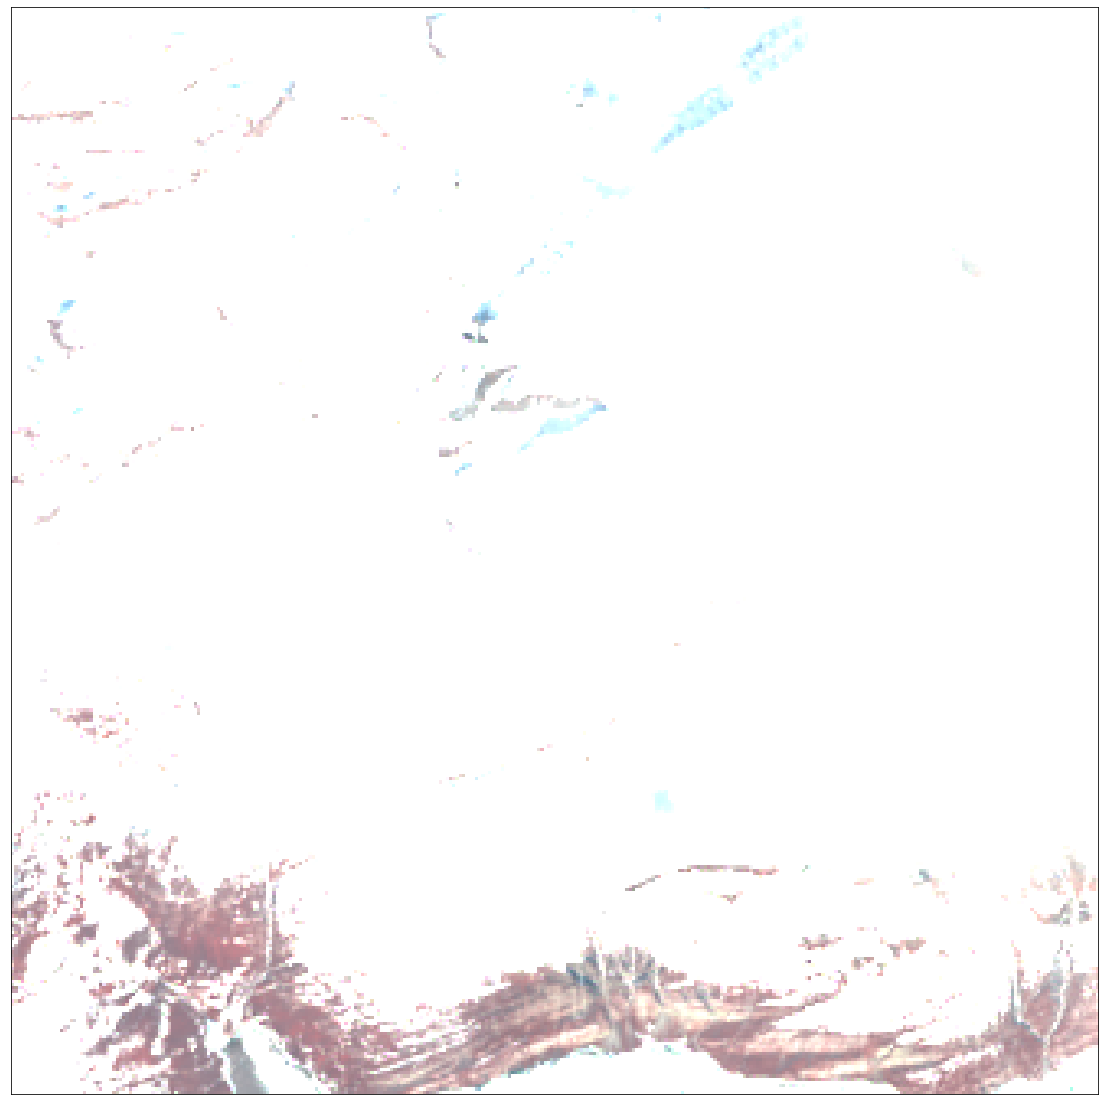

In [63]:
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch, data_acces_name='LANDSAT_RAW_BANDS' ,datetime_idx=1 )

2014-05-28 15:24:05


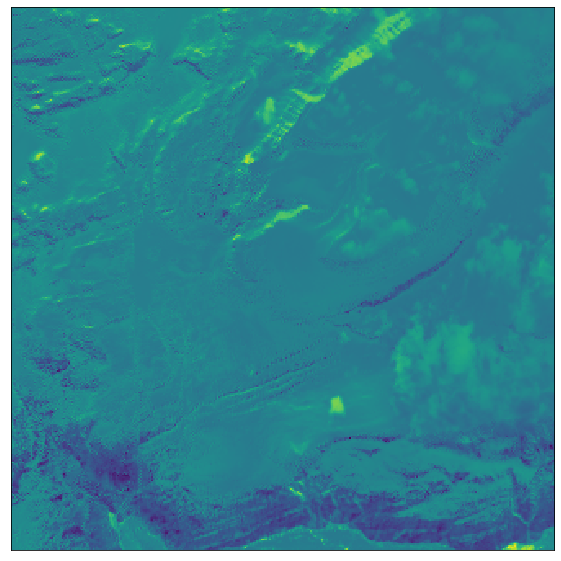

In [19]:
plot_utils.plot_single_band_LANDSAT_8(eo_patch, 0, data_acces_name = 'LANDSAT_NDWI', datetime_idx=1) 


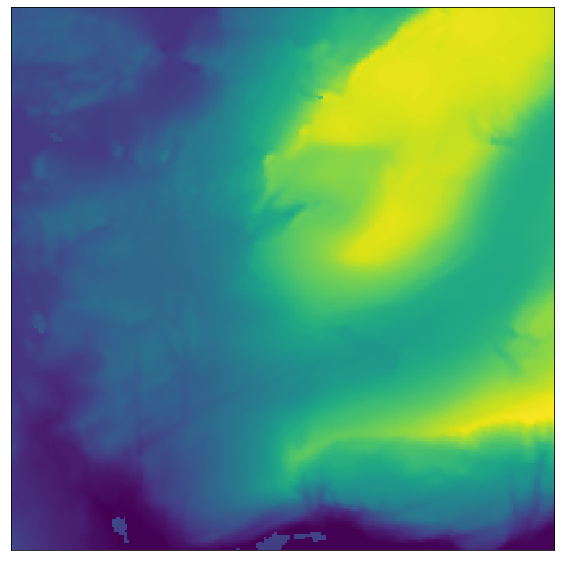

In [22]:
plot_utils.plot_timeless_mask_LANDSAT_8(eo_patch, 0) # DEM model

2014-05-03 15:30:24


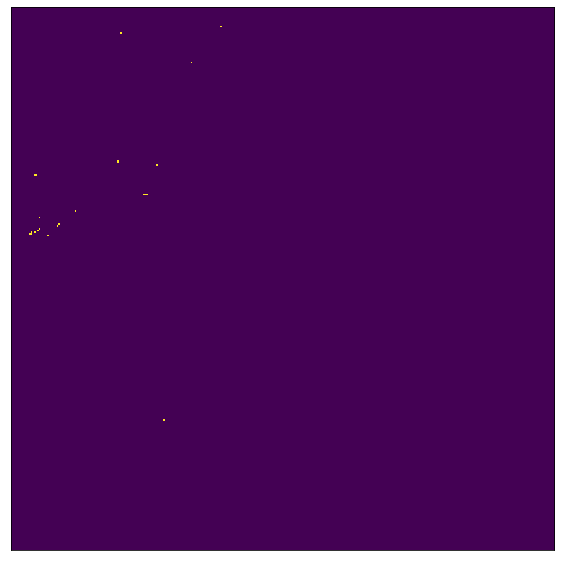

In [49]:
plot_utils.plot_qa_mask_LANDSAT_8(eo_patch, 0, datetime_idx=0) # clouds

2014-05-28 15:24:05


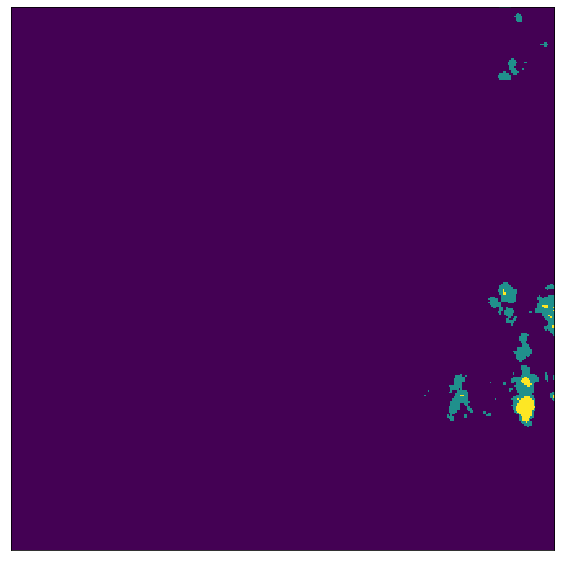

In [30]:
plot_utils.plot_qa_mask_LANDSAT_8(eo_patch, 1, datetime_idx=1) # clouds and around

2014-05-28 15:24:05


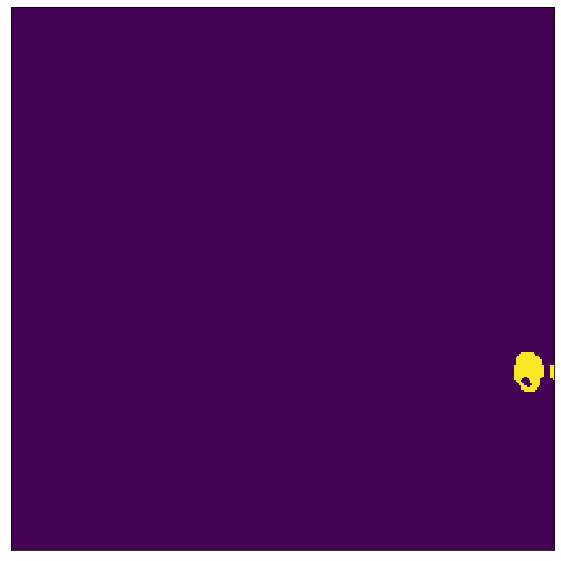

In [31]:
plot_utils.plot_qa_mask_LANDSAT_8(eo_patch, 2,  datetime_idx=1) #cloudShadowConfidence

2014-05-03 15:30:24


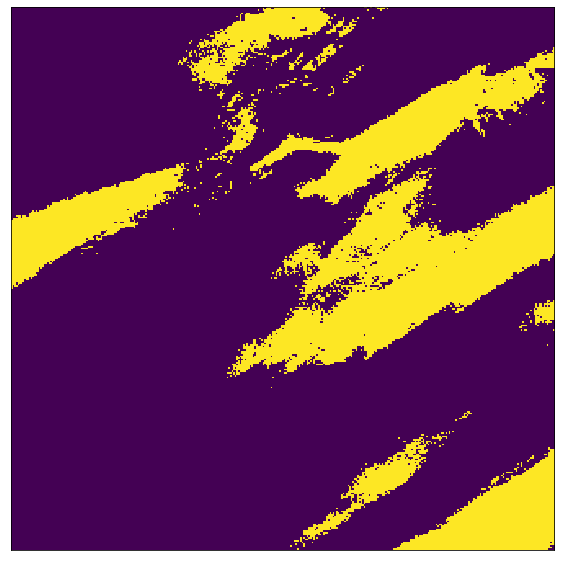

In [50]:
plot_utils.plot_qa_mask_LANDSAT_8(eo_patch, 3,  datetime_idx=0) # cirrus

2014-05-03 15:30:24


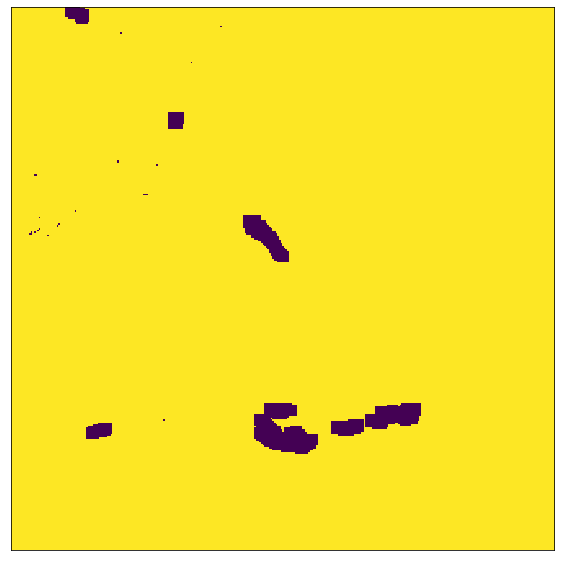

In [51]:
plot_utils.plot_qa_mask_LANDSAT_8(eo_patch, 4, datetime_idx=0)  #snow ice

In [53]:
def plot_single_band_LANDSAT_8(eopatch, band_idx, data_acces_name='LANDSAT_RAW_BANDS' ,datetime_idx =0 ):
    fig = plt.figure(figsize=(10, 10)) 
    print(eopatch.timestamp[datetime_idx])
    plt.imshow(eopatch.data[data_acces_name][datetime_idx][..., band_idx].squeeze())
    plt.xticks([])
    plt.yticks([])
    del eopatch
    return

2014-05-28 15:24:05


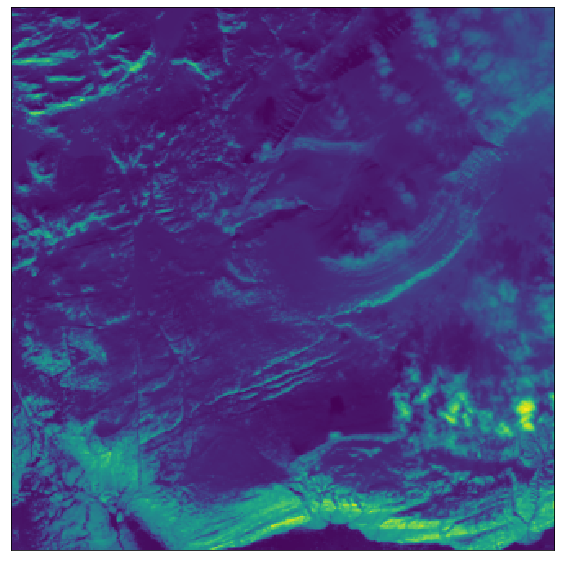

In [35]:
plot_single_band_LANDSAT_8(eo_patch, 5, data_acces_name='LANDSAT_RAW_BANDS' ,datetime_idx=0 )

In [61]:
swir  = eo_patch.data['LANDSAT_RAW_BANDS'][..., 5]
import numpy.ma as ma
mask = ma.masked_where(0.200 <= swir , swir)

([], <a list of 0 Text yticklabel objects>)

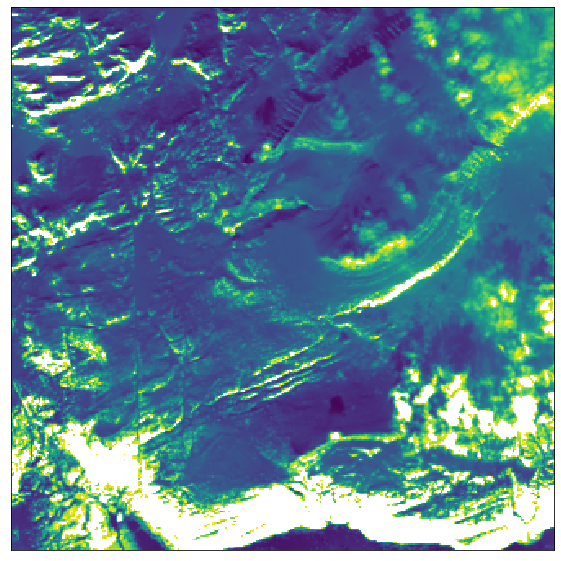

In [62]:
fig = plt.figure(figsize=(10, 10)) 
plt.imshow(mask[1].squeeze())
plt.xticks([])
plt.yticks([])

2014-08-04 00:01:06


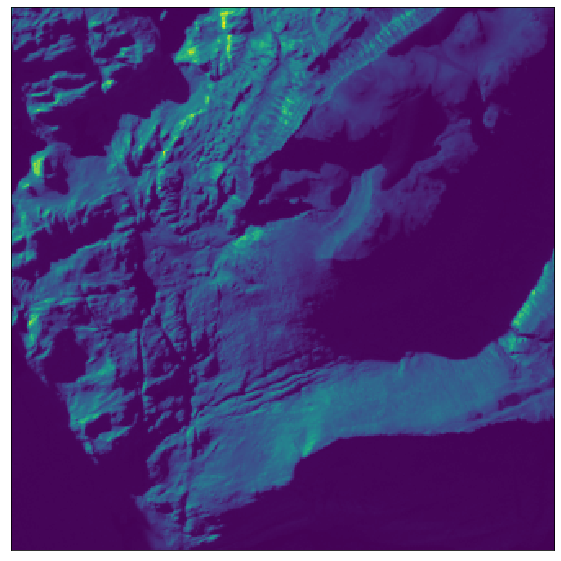

In [53]:
plot_single_band_LANDSAT_8(eo_patch, 5, data_acces_name='LANDSAT_RAW_BANDS' ,datetime_idx=5 )

([], <a list of 0 Text yticklabel objects>)

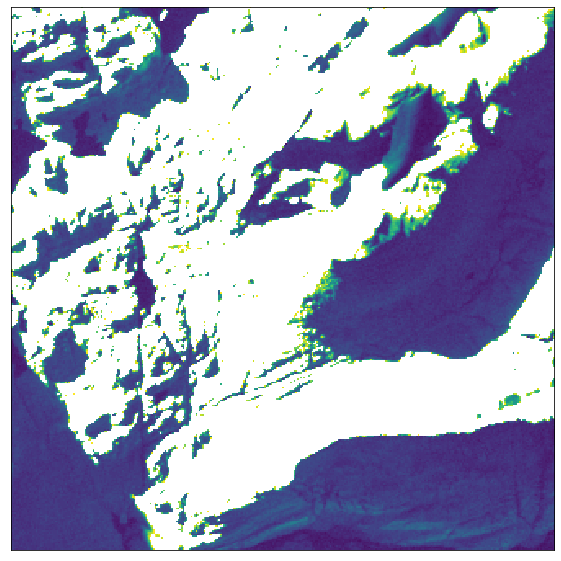

In [54]:
fig = plt.figure(figsize=(10, 10)) 
plt.imshow(mask[5].squeeze())
plt.xticks([])
plt.yticks([])

In [9]:
eo_patch_2 = EOPatch.load('../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10/2969_maxcc_0.05_x-3_y-130')
eo_patch_2

EOPatch(
  data: {
    LANDSAT_NDWI: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(7, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 11), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(7, 333, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM_RAW_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    index_x: 3
    index_y: 130
    maxcc: '0.05'
    patch_index: 2969
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
    size_y: '30m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2013-05-01', '2013-10-31')
  }
  bbox: BBox(((400000.0, 8030000.0), (410000.0, 8040000.0)), crs=EPSG:32622)
  timestamp: [datetime.datetime(2013, 5, 25, 15, 26, 35), ..., datetime.datetime(2013, 9, 30, 15, 26, 

EOPatch(
  data: {
    LANDSAT_NDWI: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(7, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 11), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(7, 333, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM_RAW_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    index_x: 3
    index_y: 130
    maxcc: '0.05'
    patch_index: 2969
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
    size_y: '30m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2013-05-01', '2013-10-31')
  }
  bbox: BBox(((400000.0, 8030000.0), (410000.0, 8040000.0)), crs=EPSG:32622)
  timestamp: [datetime.datetime(2013, 5, 25, 15, 26, 35), ..., datetime.datetime(2013, 9, 30, 15, 26, 

2013-05-25 15:26:35
2013-05-25 15:26:35


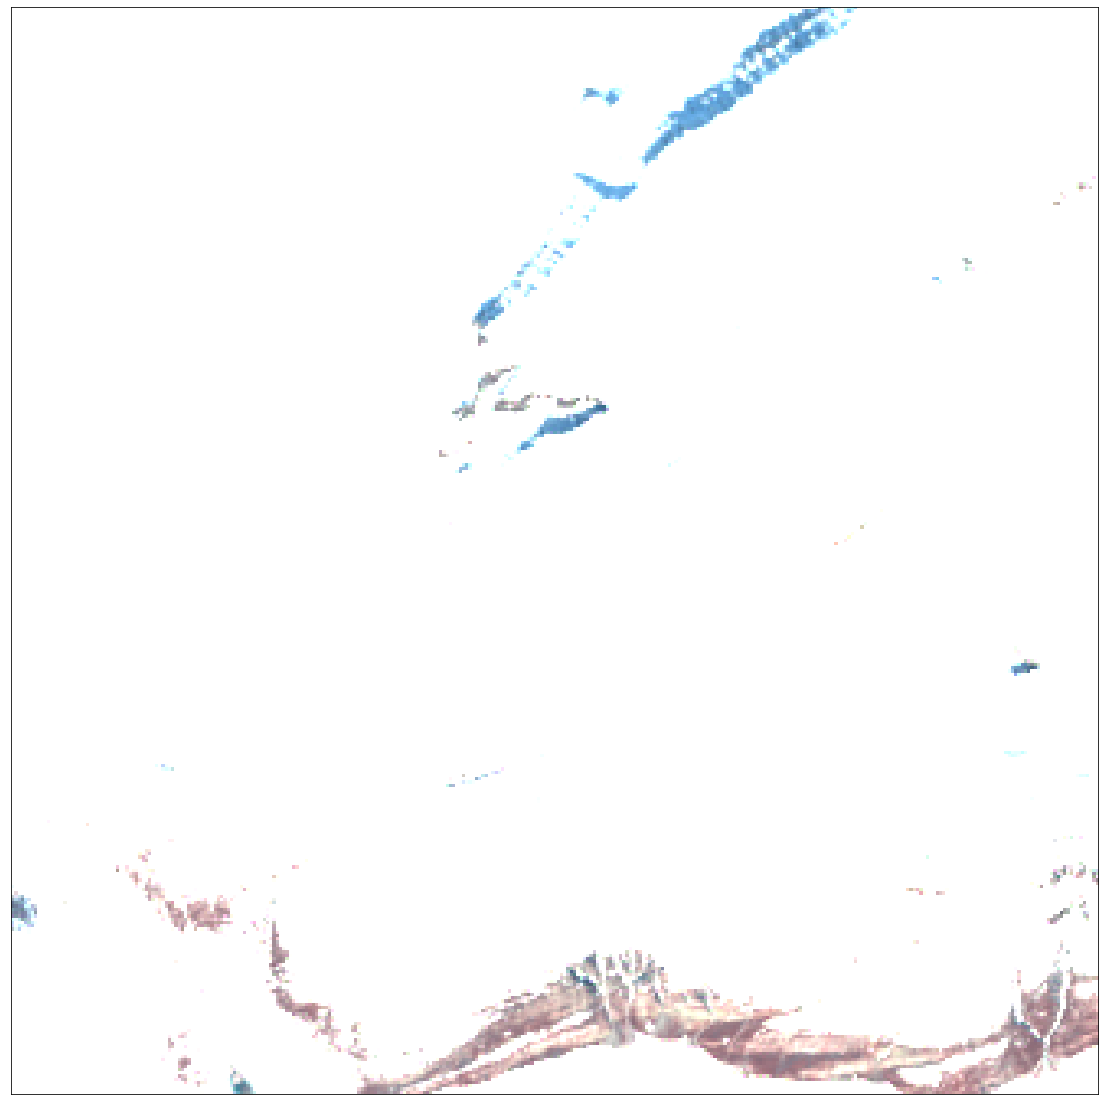

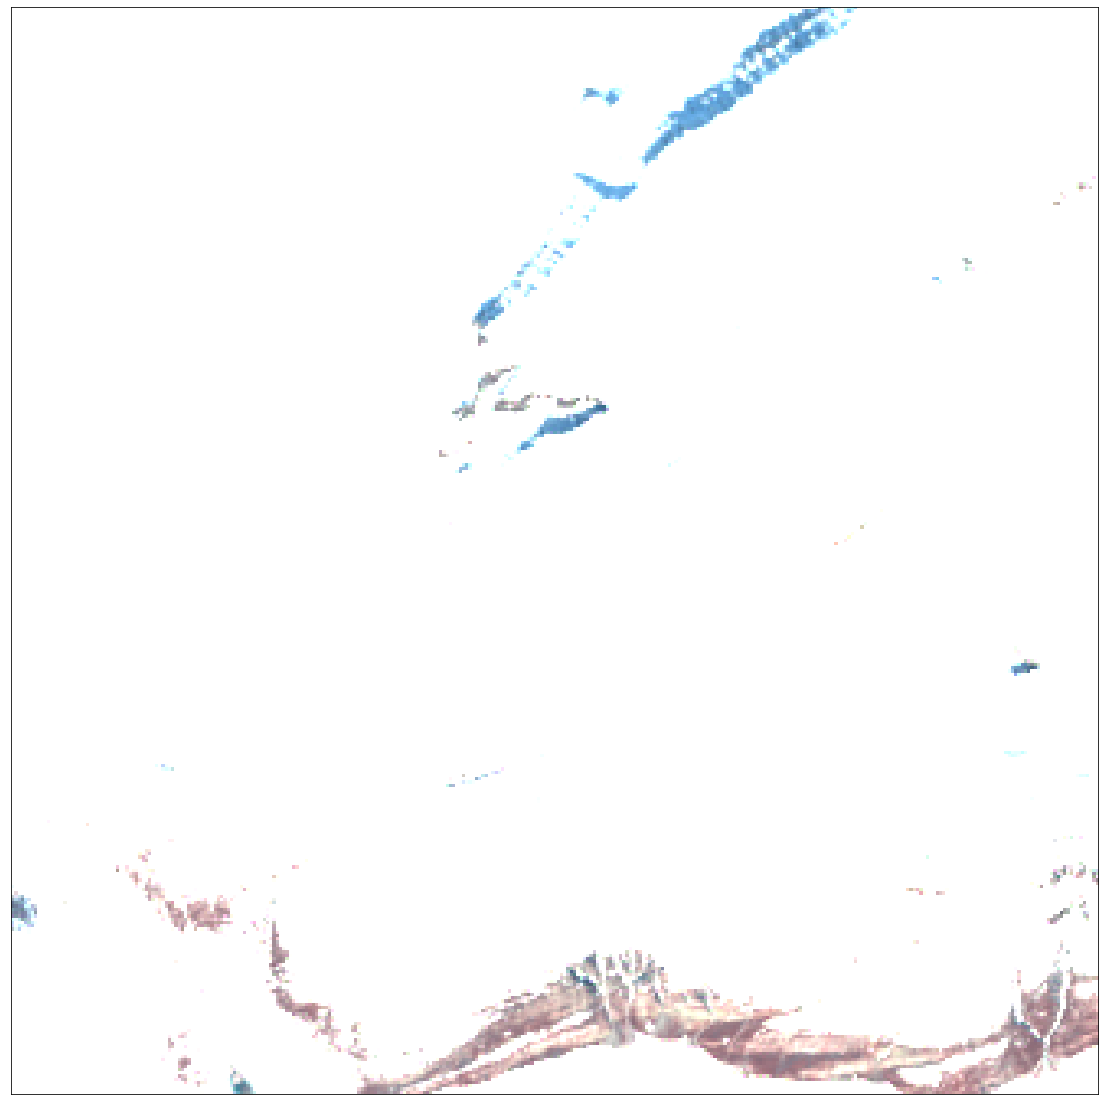

In [49]:
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch_2, data_acces_name='LANDSAT_RAW_BANDS' ,datetime_idx=0 )

2013-09-14 15:26:31
2013-09-14 15:26:31


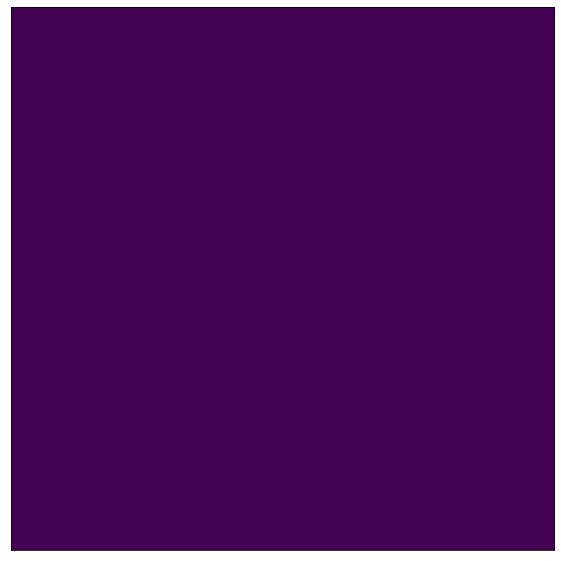

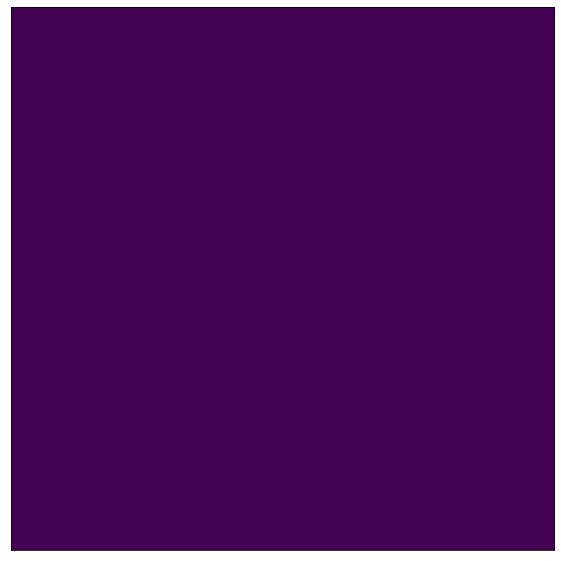

In [27]:
plot_utils.plot_qa_mask_LANDSAT_8(eo_patch_2, 0, datetime_idx=2) # clouds

2013-09-14 15:26:31
2013-09-14 15:26:31


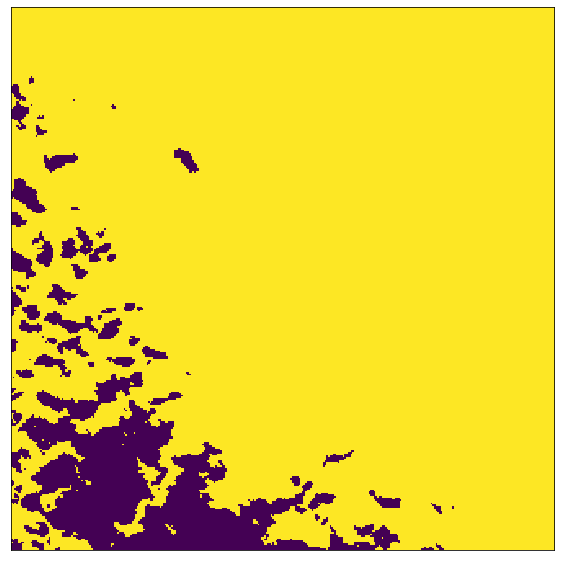

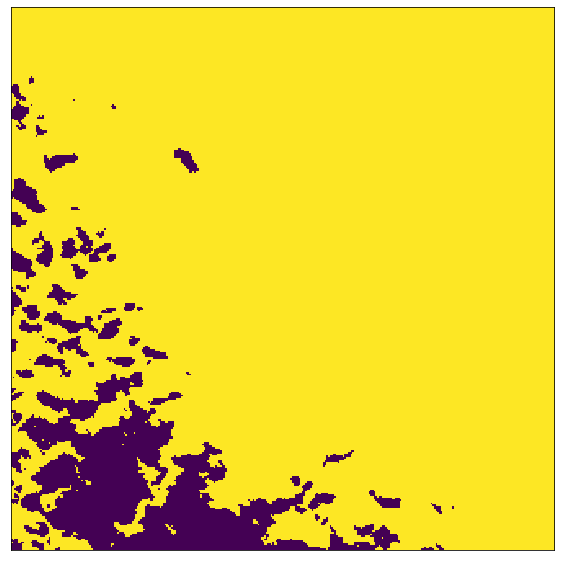

In [28]:
plot_utils.plot_qa_mask_LANDSAT_8(eo_patch_2, 4, datetime_idx=2)  #snow ice

2013-05-25 15:26:35
2013-05-25 15:26:35


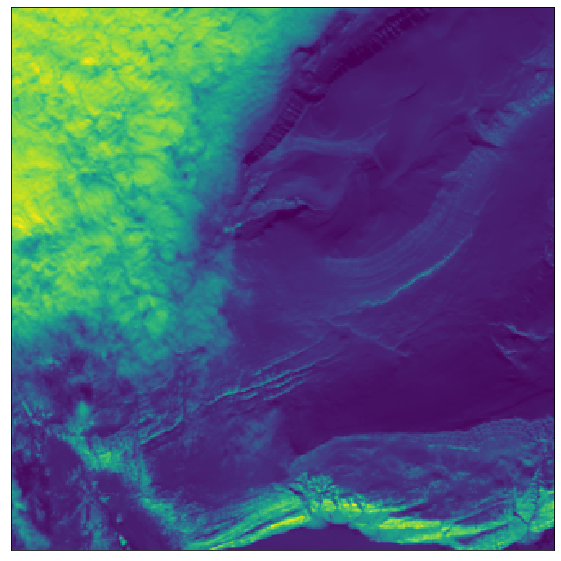

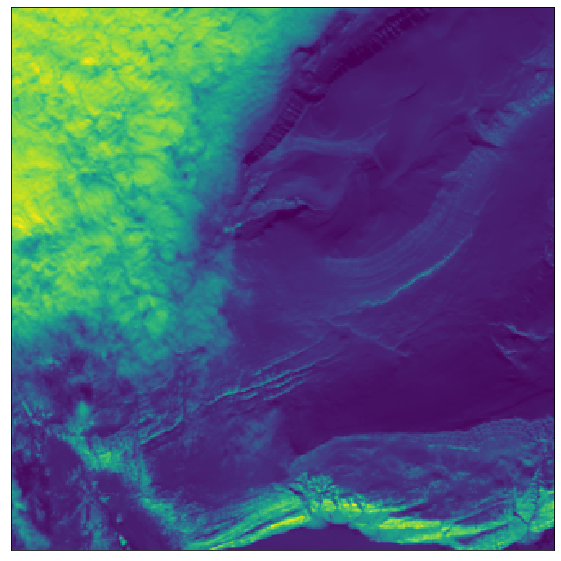

In [55]:
plot_single_band_LANDSAT_8(eo_patch_2, 5, data_acces_name='LANDSAT_RAW_BANDS' ,datetime_idx=0 )

In [52]:
swir_2  = eo_patch_2.data['LANDSAT_RAW_BANDS'][..., 6]
import numpy.ma as ma
mask_2 = ma.masked_where(0.100 <= swir_2 , swir_2)

([], <a list of 0 Text yticklabel objects>)

([], <a list of 0 Text yticklabel objects>)

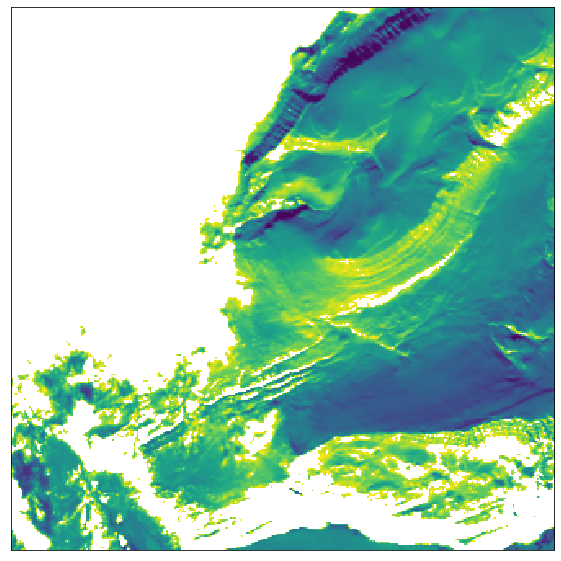

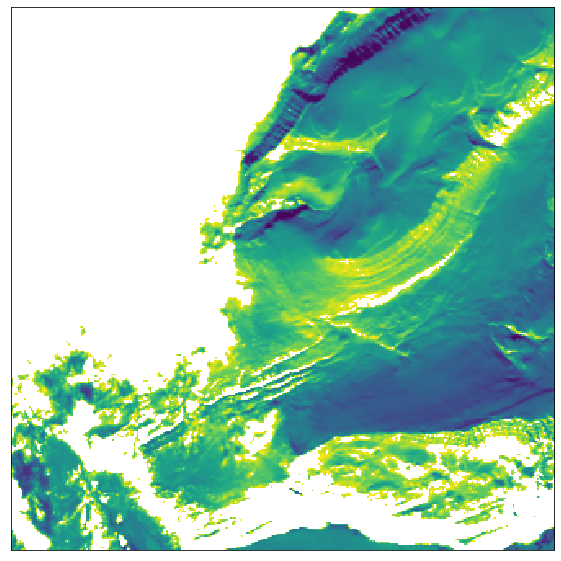

In [48]:
fig = plt.figure(figsize=(10, 10)) 
plt.imshow(mask_2[0].squeeze())
plt.xticks([])
plt.yticks([])